In [51]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, max_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

# Function to load dataset from file and apply basic data cleaning
def load_coin_data(data_file='../../data/crypto-markets.csv'):
    try:
        df = pd.read_csv(data_file)
    except FileNotFoundError:
        print("ERROR: data file not found")
        return None
    
    # Convert date column from string to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Align all end dates to '2018-11-29'
    df = df[df['date'] != '2018-11-30']

    # Sort the dataset by 'slug' and 'date'
    df = df.sort_values(['slug', 'date'])

    # Add next closing price and next day return columns
    df['next_close'] = df.groupby('slug')['close'].shift(-1)
    df['next_return'] = (df['next_close'] - df['close']) / df['close']

    # Drop the last row of each coin as we don't have the next day's closing price
    df = df.dropna()

    # Reset the dataframe index
    df = df.reset_index(drop=True)

    return df

 

In [47]:
# Function to filter dataset to only contain coins with specific number of years of data
def filter_by_years(df, years=4):
    return df.groupby('slug').filter(lambda x: len(x) > (365 * years)).reset_index(drop=True)

# Function to split dataset by specific date
def split_train_test(df, date='2017-11-28'):
    train = df.loc[df['date'] < date].reset_index(drop=True)
    test = df.loc[df['date'] >= date].reset_index(drop=True)
    return train, test

# Load data
DATA_FILE = '../../data/crypto-markets.csv'
df = load_coin_data(DATA_FILE)

# Filter data with a slug named 'bitcoin'
btc_data = df[df['slug'] == 'bitcoin']

# Filter to coins with 4+ years of data
btc_data = filter_by_years(btc_data)

# Sort by date descending
sorted_btc_data = btc_data.sort_values('date', ascending=False)


sorted_btc_data['T-1'] = sorted_btc_data['close'].shift(-1)
sorted_btc_data['T-2'] = sorted_btc_data['close'].shift(-2)
sorted_btc_data['T-3'] = sorted_btc_data['close'].shift(-3)
sorted_btc_data['T-4'] = sorted_btc_data['close'].shift(-4)
sorted_btc_data['T-5'] = sorted_btc_data['close'].shift(-5)

sorted_btc_data['close_price_change%'] =(((sorted_btc_data['close']/sorted_btc_data['T-1'])- 1) * 100).map("{:.2f}%".format)

sorted_btc_data['MA_5'] = sorted_btc_data['close'].rolling(window=3, min_periods=1).mean()
sorted_btc_data['MA_5_change%'] = (
    (sorted_btc_data['MA_5'] / sorted_btc_data['close'].shift(-1) - 1) * 100)


In [52]:
# Drop rows with NaN values resulting from shifting
sorted_btc_data = sorted_btc_data.dropna()

# Split data into train and test datasets using the custom split function
train, test = split_train_test(sorted_btc_data)

# Define features (X) and target (y) for training and testing
X_train = train[['T-1', 'T-2', 'T-3', 'T-4', 'T-5', 'MA_5_change%']]
y_train = train['close']
X_test = test[['T-1', 'T-2', 'T-3', 'T-4', 'T-5', 'MA_5_change%']]
y_test = test['close']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Best k: 1
Test RMSE: 2166.91
               Metric        Value
0  Explained Variance     0.537125
1           Max Error  9679.050000
2                RMSE  2166.912526
3                 MAE  1220.049481
4           R-Squared     0.489551


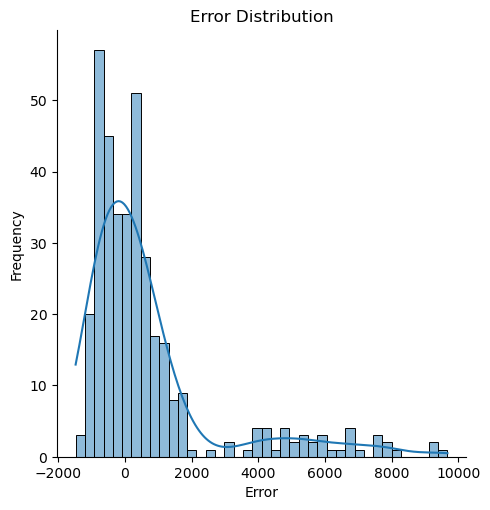

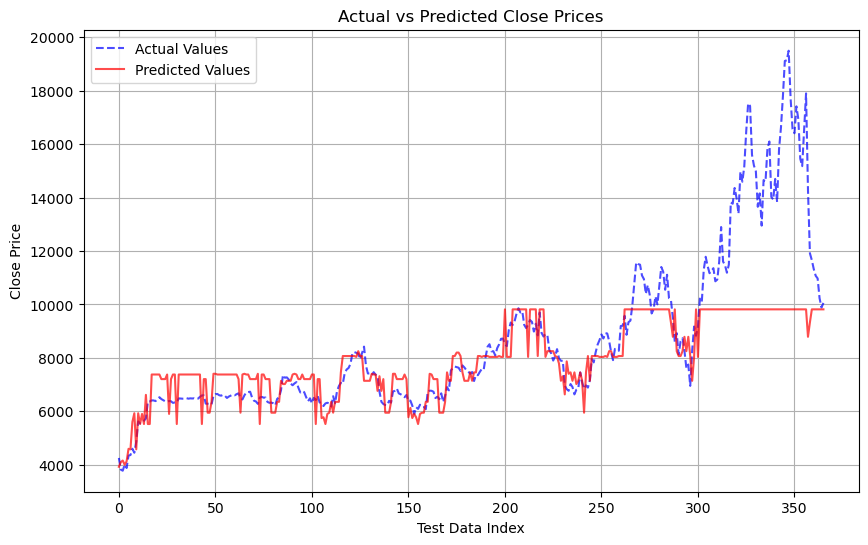

In [53]:
# Grid search with cross-validation on the training set
param_grid = {'n_neighbors': range(1, 21)}  # Test k from 1 to 20
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_k = grid_search.best_params_['n_neighbors']
print(f"Best k: {best_k}")

# Train final KNN model with the best `k`
best_knn = grid_search.best_estimator_


# Evaluate on the test set
predicted = best_knn.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, predicted))
print(f"Test RMSE: {rmse:.2f}")

# Calculate additional metrics
explained_variance = explained_variance_score(y_test, predicted)
max_error_value = max_error(y_test, predicted)
mae = mean_absolute_error(y_test, predicted)
r_squared = r2_score(y_test, predicted)

# Create a DataFrame for metrics
metrics = {
    'Metric': ['Explained Variance', 'Max Error', 'RMSE', 'MAE', 'R-Squared'],
    'Value': [explained_variance, max_error_value, rmse, mae, r_squared]
}

metrics_df = pd.DataFrame(metrics)

# Display the metrics table
print(metrics_df)

# Graph 1: Error distribution plot
error = y_test - predicted
sns.displot(error, kde=True, bins=40)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Graph 2: Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Values', color='blue', linestyle='dashed', alpha=0.7)
plt.plot(predicted, label='Predicted Values', color='red', alpha=0.7)
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Test Data Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()
